Importing the libraries.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import pandas as pd
import requests
from io import BytesIO
import shapely

Getting all order types on 6 points.

In [3]:
def read_order_types_for_df(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    df = pd.DataFrame(points, columns=['x', 'y'], dtype=dtype)
    return df

def read_order_types(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    return points


file_url = "http://www.ist.tugraz.at/staff/aichholzer/research/rp/triangulations/ordertypes/data/otypes06.b08"

# downloading set points
response = requests.get(file_url)
file_content = response.content

# Use BytesIO to create a file-like object from the bytes content
file_like_object = BytesIO(file_content)


# Reading content into data frame
file_content_array = np.frombuffer(file_like_object.getvalue(), dtype=np.uint8)
df = read_order_types_for_df(file_content_array)
df.head()

data = read_order_types(file_content_array)
data = list(data)
data = [tuple(x) for x in data]
data[:5]

[(230, 192), (248, 78), (148, 36), (54, 72), (30, 160)]

Functions made to generate all caterpillars, not used at this time.

In [4]:
def is_sym_or_forward(seq, d):
  if seq == seq[::-1]: return True
  for i in range(d-2):
    if seq[i] != seq[d-i-2]:
      if seq[i] > seq[d-i-2]: return True
      return False

def find_s(seq, d):
  j = d-3
  while seq[j] == 0: j-=1
  return j

def new_seq(seq):
  l = len(seq)
  if l == 1: return [int(seq[0]+2)]
  if l == 2: return [int(seq[0]+1), int(seq[1]+1)]
  return [int(seq[0]+1)] + [int(seq[i]) for i in range(1,l-1)] + [int(seq[l-1]+1)]

def generate_caterpillars(n,d=None):
  if d is None:
    cs = []
    for d in range(2,n):
      cs += generate_caterpillars(n,d)
    return cs
  c = [n-d-1] + list(np.zeros(d-2))
  cs = [new_seq(c)]
  while sum(c[:d-2]) > 0:
    s = find_s(c, d)
    if s == d-3:
      c[d-3] -= 1
      c[d-2] += 1
    else:
      c[s] -= 1
      c[s+1] = 1 + c[d-2]
      c[d-2] = 0
    if is_sym_or_forward(c,d):
      cs.append(new_seq(c))
  return cs

All other functions we need:


*   checking whether two line segments intersect
*   transforming a caterpillar given as sequence of the same length as spine, where each item is number of leaves at that spine vertex, into a graph object
*   checking whether a graph is planar
*   finding empty triangles in a graph (i.e. places where a slide can be made)
*   checking whether a graph is a caterpillar



In [5]:

def intersect(A,B,C,D):
  if len(set([A,B,C,D])) == 4:
    line = shapely.LineString([A,B])
    other = shapely.LineString([C,D])
    return line.intersects(other)
  return False


def seq_to_caterpillar(c):
  l = len(c)
  g = nx.path_graph(l)
  spent = l
  for i in range(l):
    nx.add_star(g,[i]+[spent+j for j in range(c[i])])
    spent += c[i]
  return g

def check_planar(g):
  pos = nx.get_node_attributes(g, 'pos')
  edges = list(g.edges)
  for C in itertools.combinations(edges,2):
    e = C[0]
    f = C[1]
    if intersect(pos[e[0]],pos[e[1]],pos[f[0]],pos[f[1]]): return False
  return True

def check_empty_triangles(G):
  pos = nx.get_node_attributes(G, 'pos')
  vertices = set(range(n))
  empty_triangs = []
  for triang in itertools.combinations(range(n),3):
    a,b,c=triang
    if not len(set(((a,b),(a,c),(b,c))).intersection(set(G.edges))) == 2: continue
    t = shapely.convex_hull(shapely.MultiPoint([pos[a],pos[b],pos[c]]))
    rest = list(vertices.difference(triang))
    empty = True
    for p in rest:
      if t.contains(shapely.Point(pos[p])): empty = False
    if empty: empty_triangs.append(triang)
  return empty_triangs

def is_caterpillar(G):
  spine = []
  leaf = []
  for i in range(n):
    if G.degree(i) == 1: leaf.append(i)
    else: spine.append(i)
  G.remove_nodes_from(leaf)
  if max([p[1] for p in G.degree]) > 2:return False
  return True

In [172]:
generate_caterpillars(7)

[[6],
 [4, 1],
 [3, 2],
 [3, 0, 1],
 [2, 1, 1],
 [2, 0, 2],
 [1, 2, 1],
 [2, 0, 0, 1],
 [1, 1, 0, 1],
 [1, 0, 0, 0, 1]]

In order to check if the slide graph of caterpillars on $7$ points is connected we use the following observation.

**Obs**: *A caterpillar on $7$ points that is not a path has spine at with at most $4$ vertices.*

If the spine has $3$ vertices or less then it is connected to a star by Lemma $3$. So we only focus on the case where the spine has $4$ vertices, i.e when the caterpillar is $P_6$ plus an edge.

In this case, we use the following observation:

**Obs**: *If a caterpillar on* $7$ *points is composed of* $P_6$ *plus an edge and if the embedding of* $P_6$ *has either* $2$ *empty triangles or* $1$ *empty triangle (empty from the rest of* $P_6$*)* $v_i,v_{i+1},v_{i+2}$ *such that the only vertices that see the interior of the triangle* $v_i,v_{i+1},v_{i+2}$ *are* $v_{i+3}$ *and* $v_{i-1}$ *then the caterpillar can be transformed into a star.*

Therefore we just need to see if this holds for all possible embeddings of $P_6$ which is what we do below.

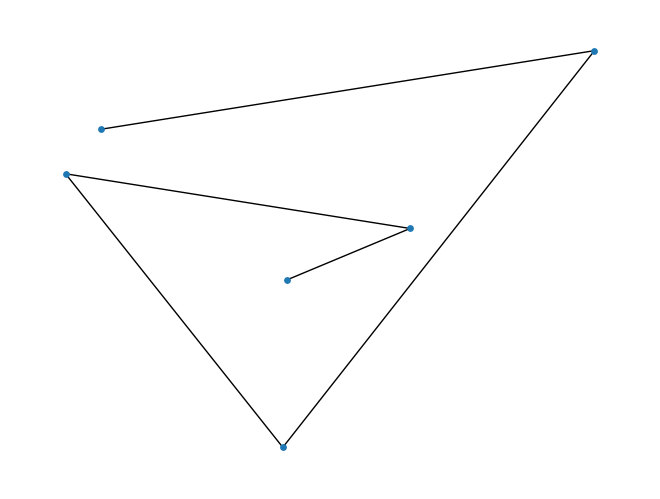

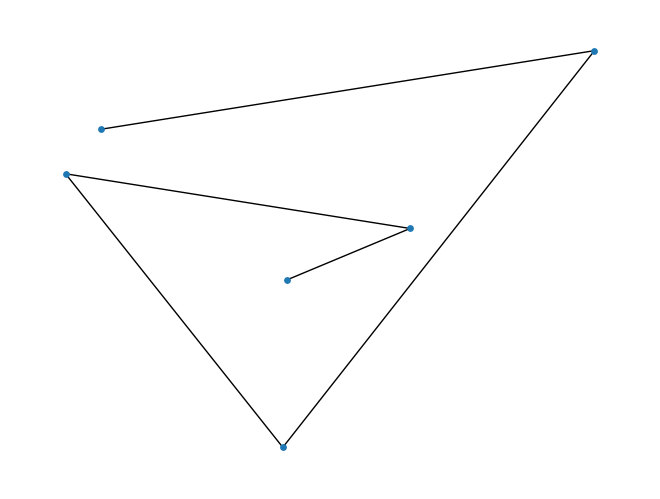

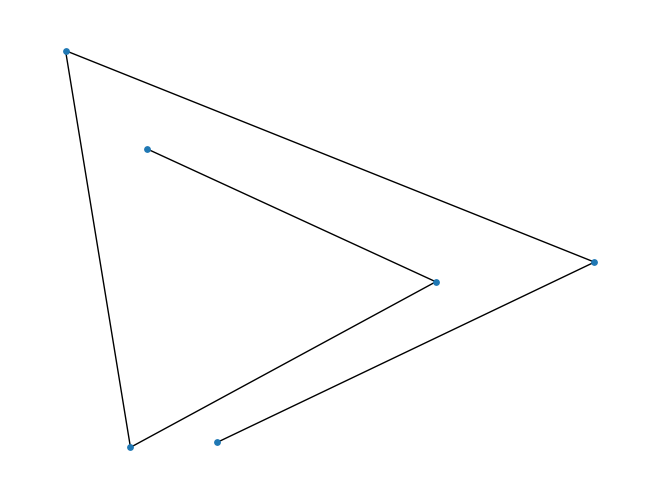

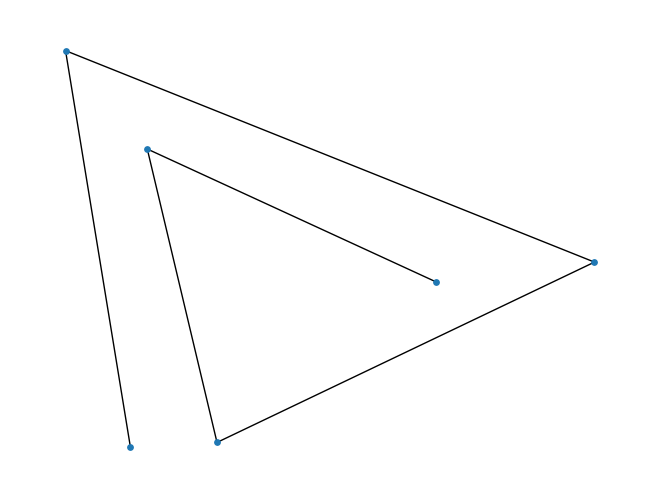

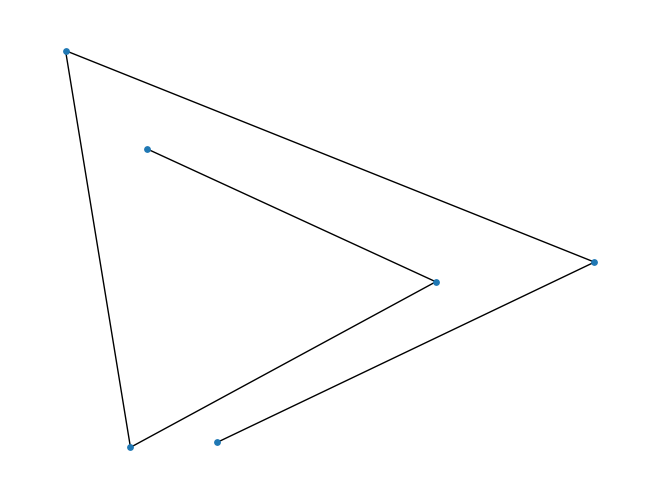

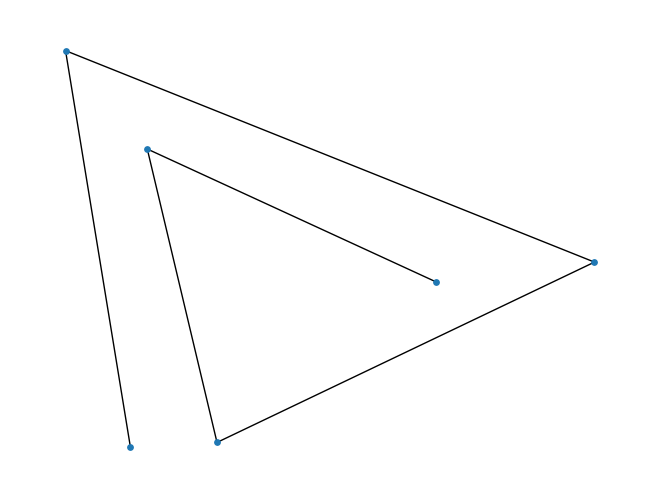

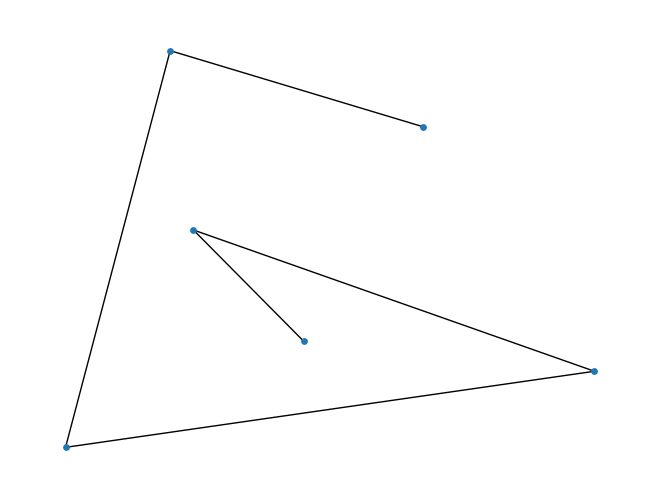

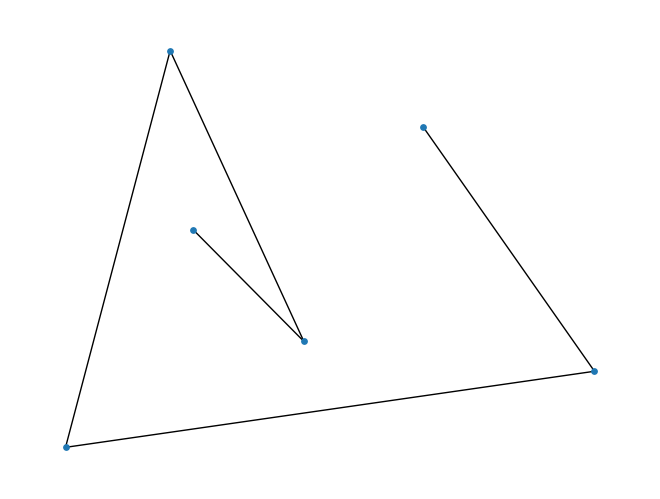

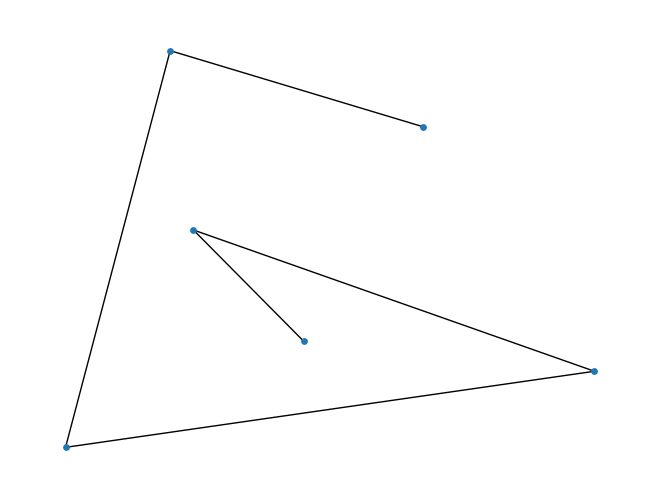

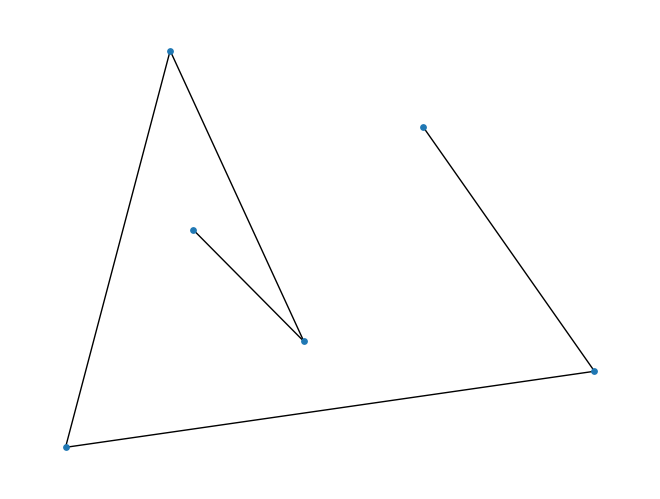

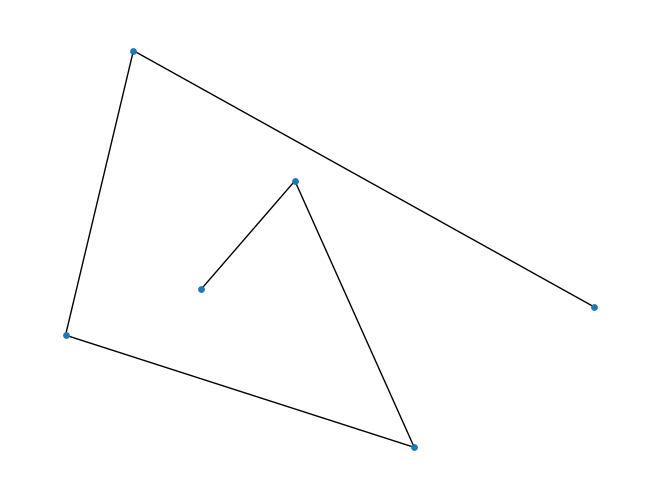

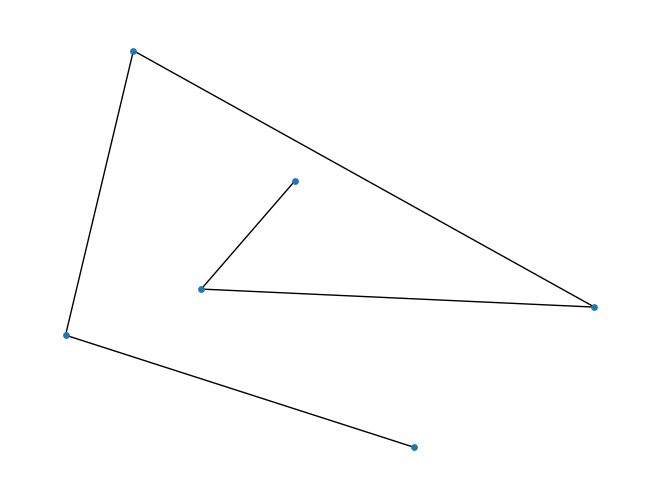

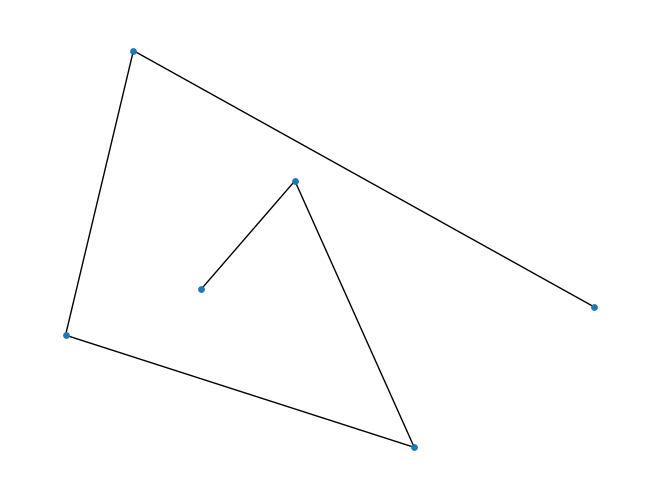

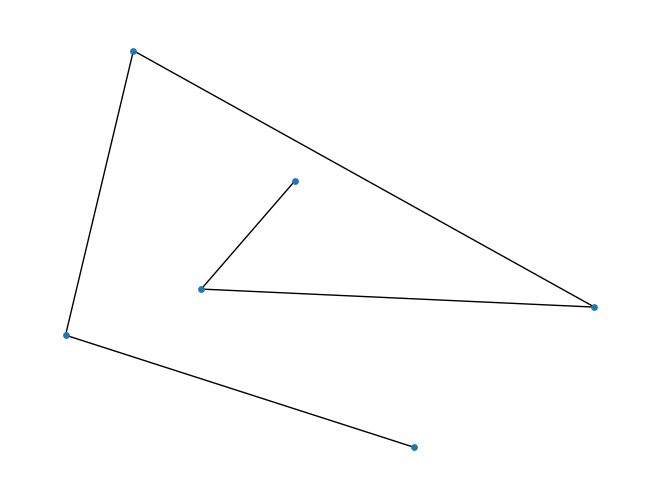

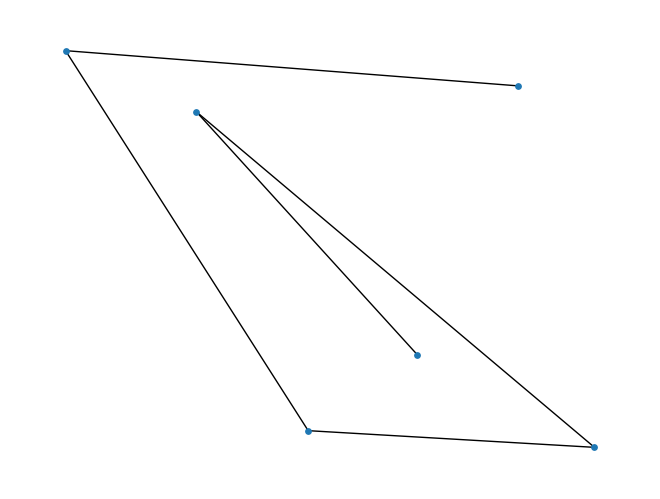

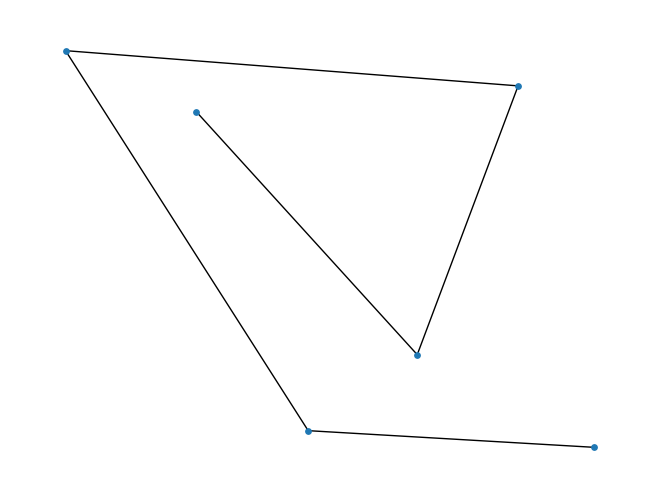

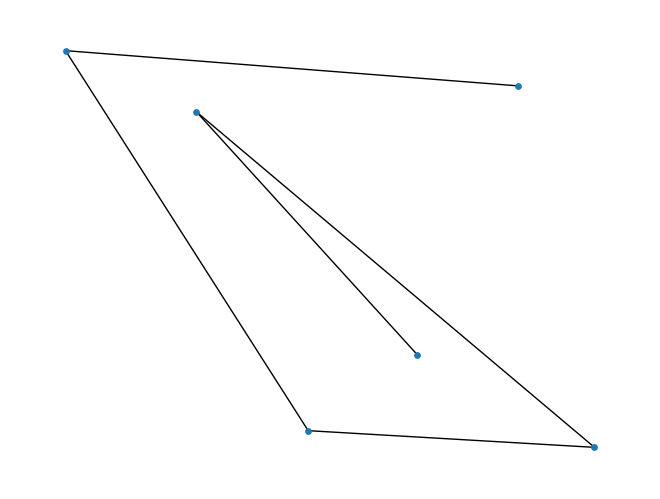

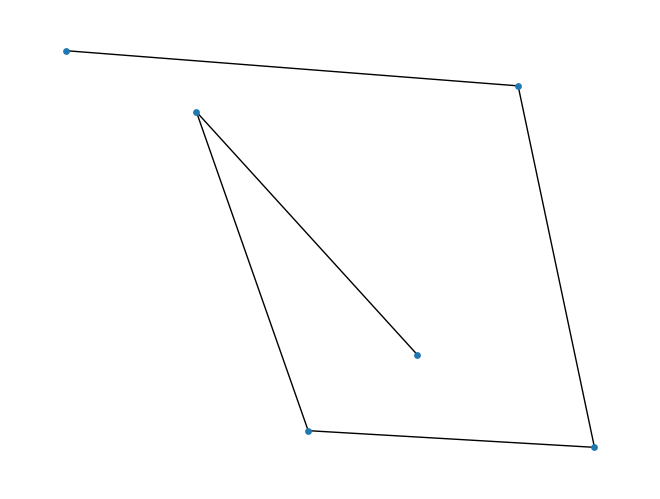

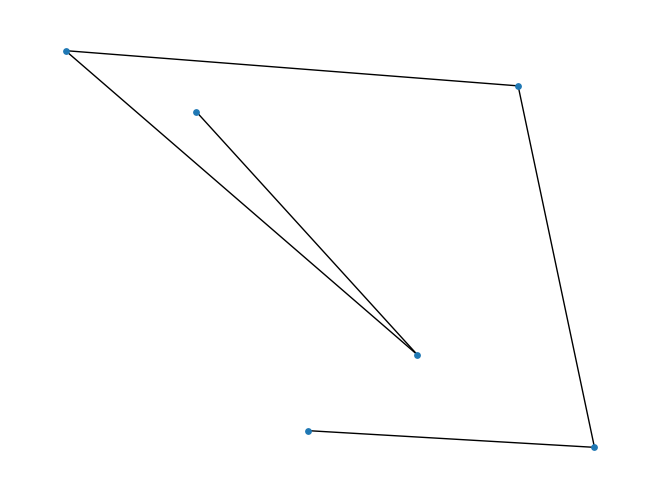

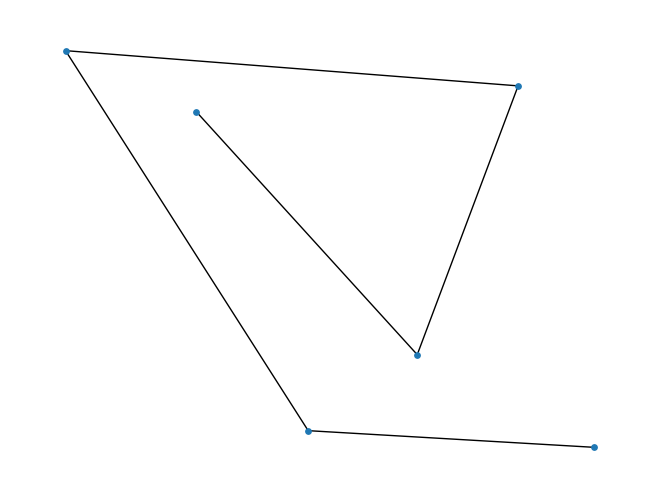

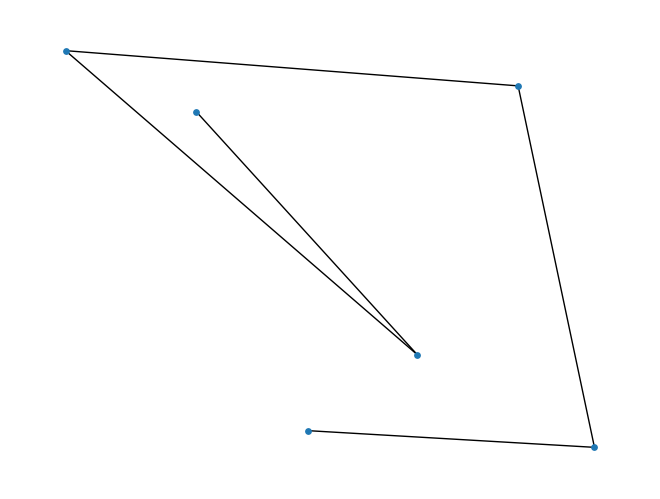

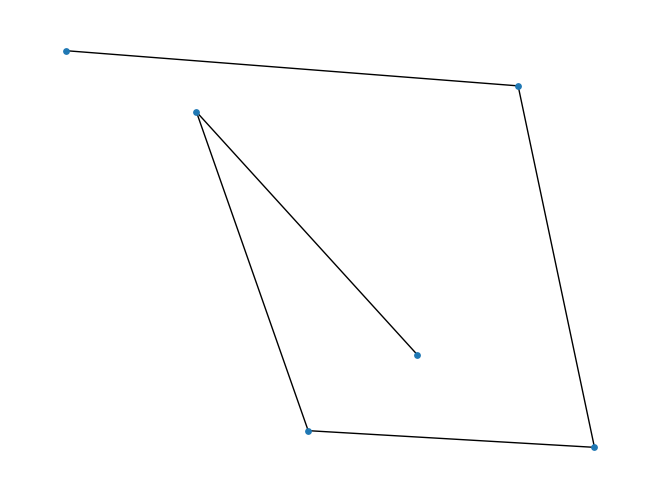

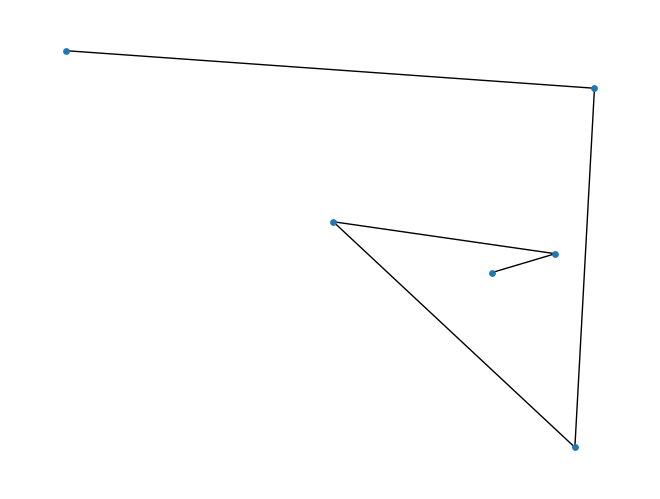

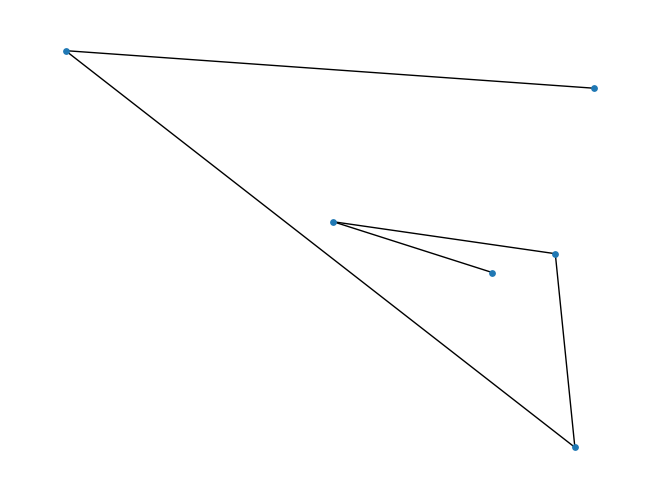

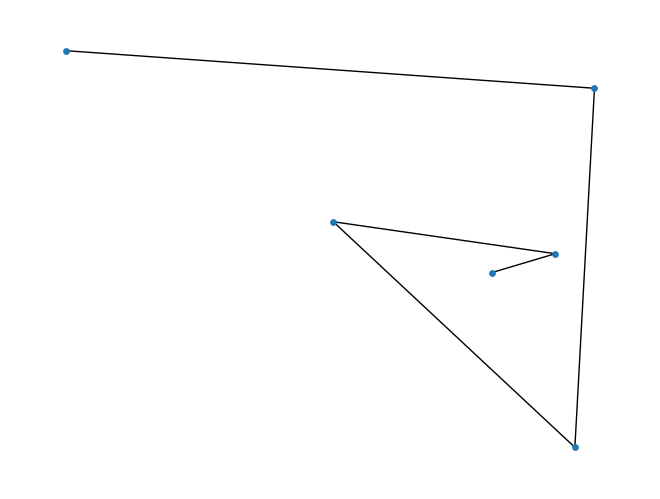

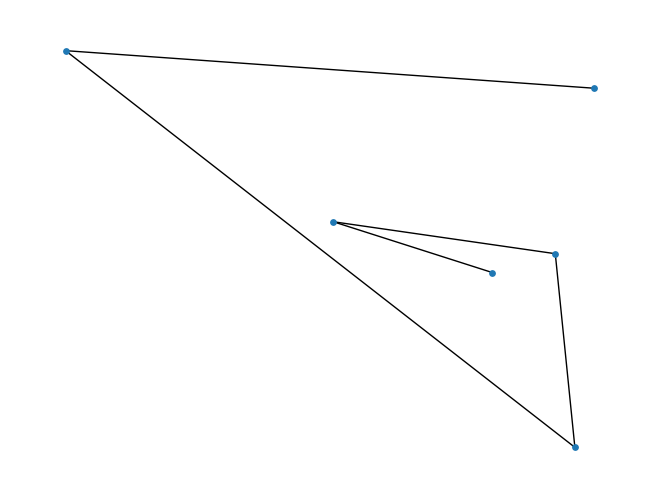

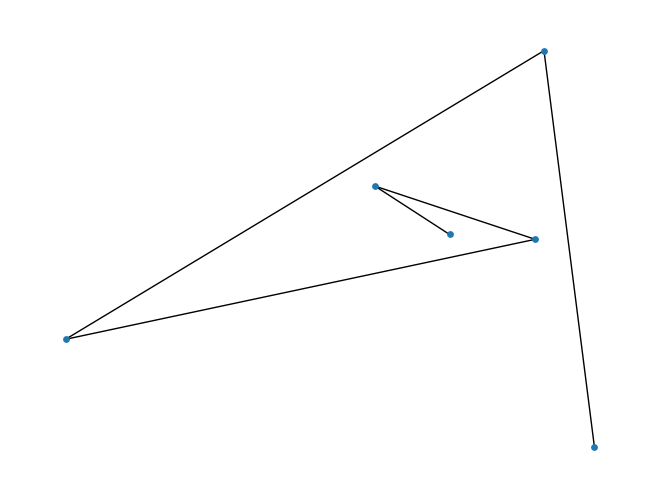

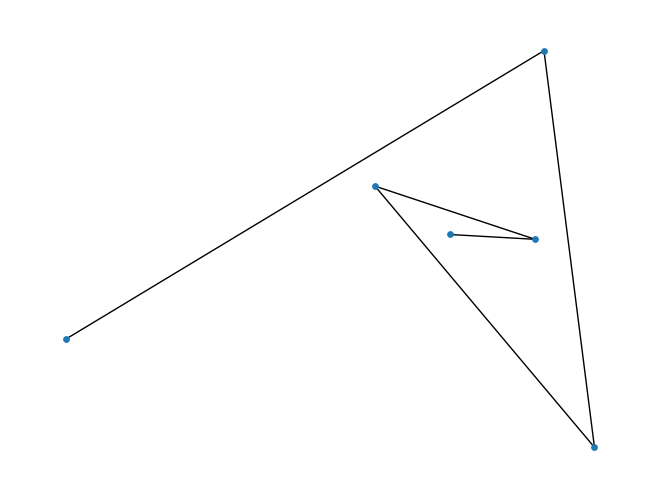

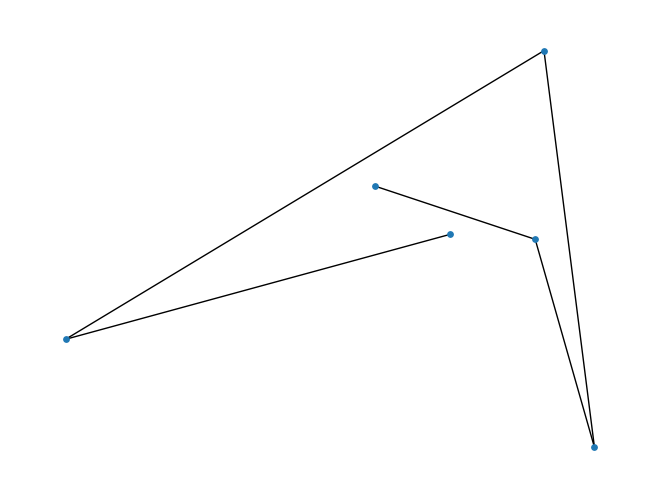

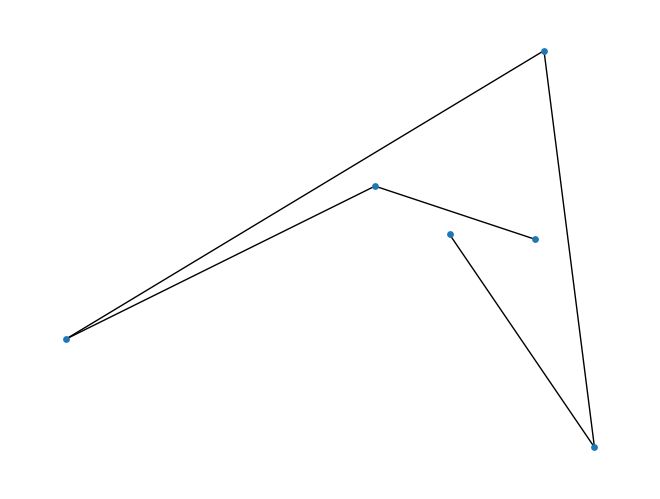

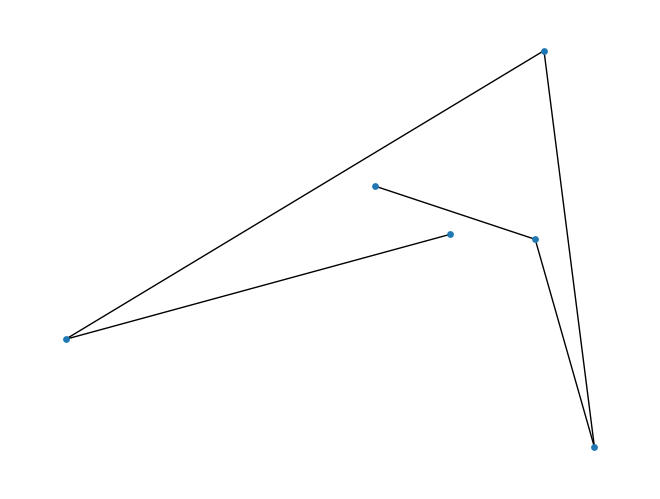

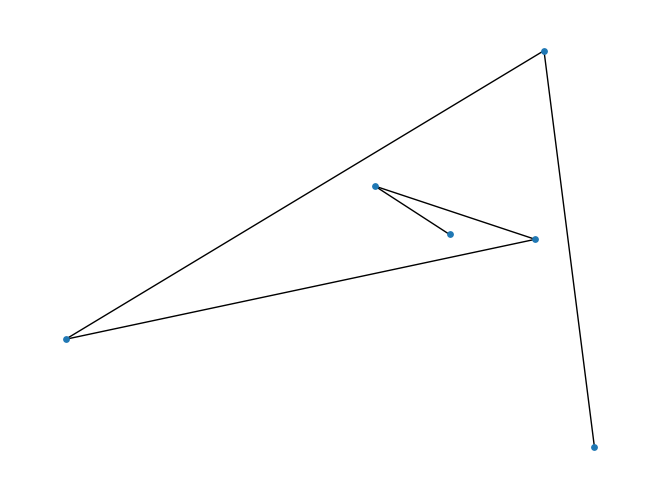

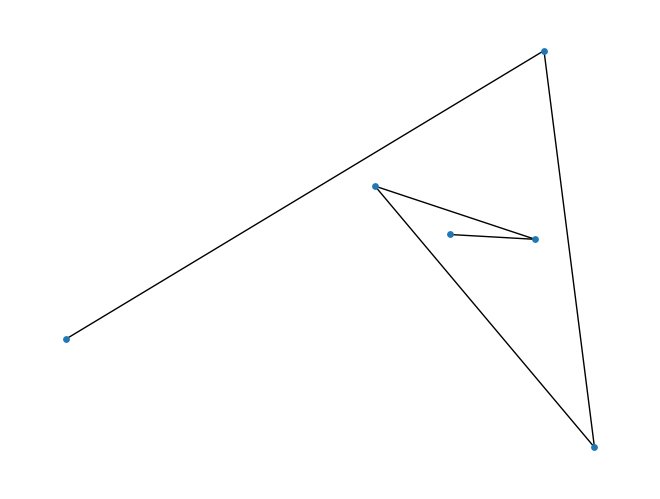

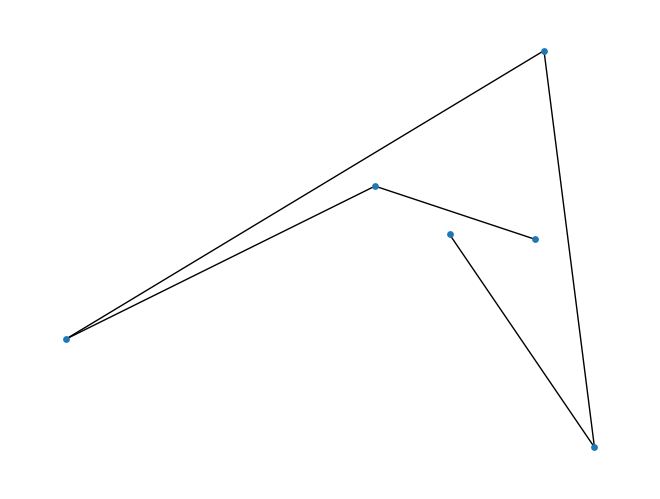

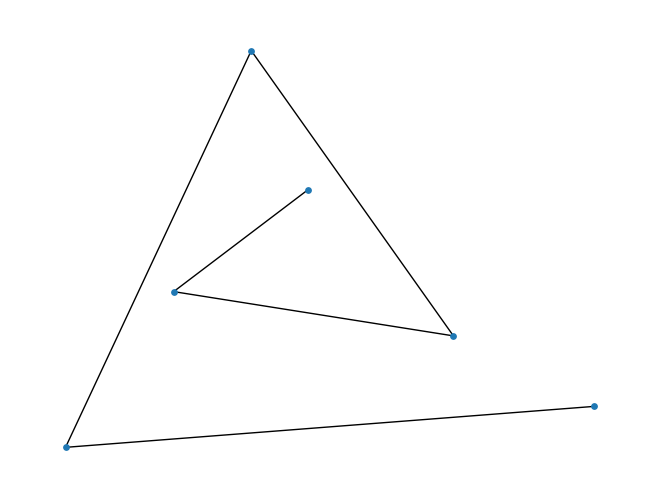

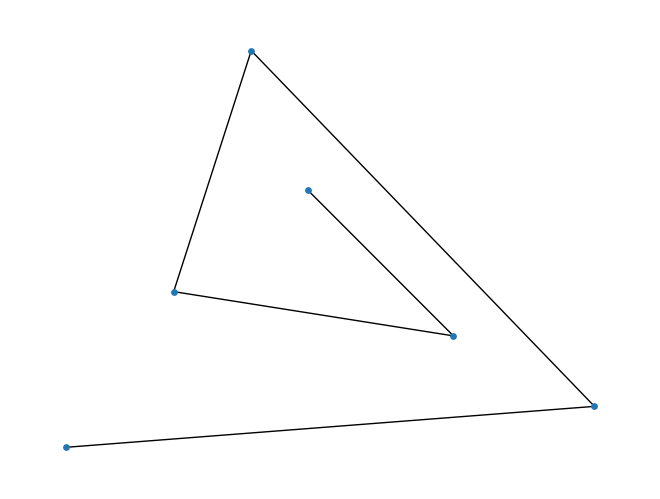

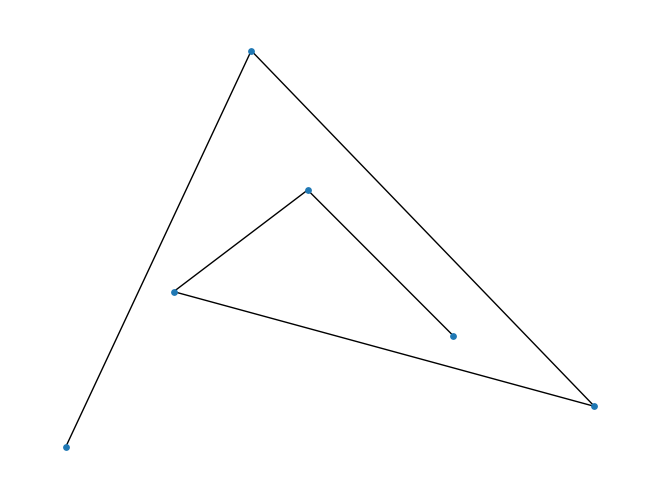

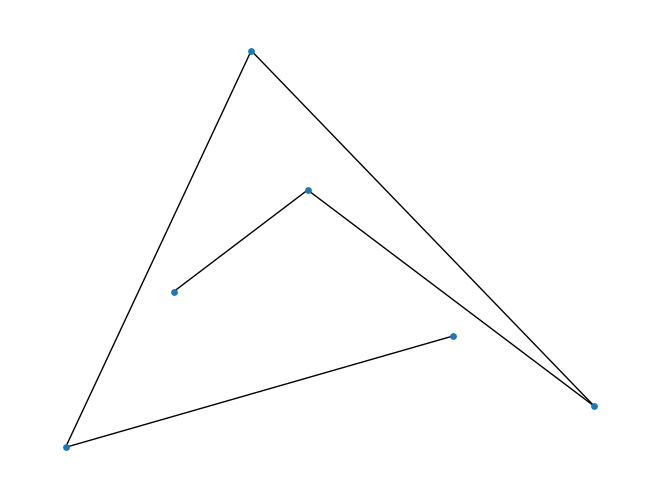

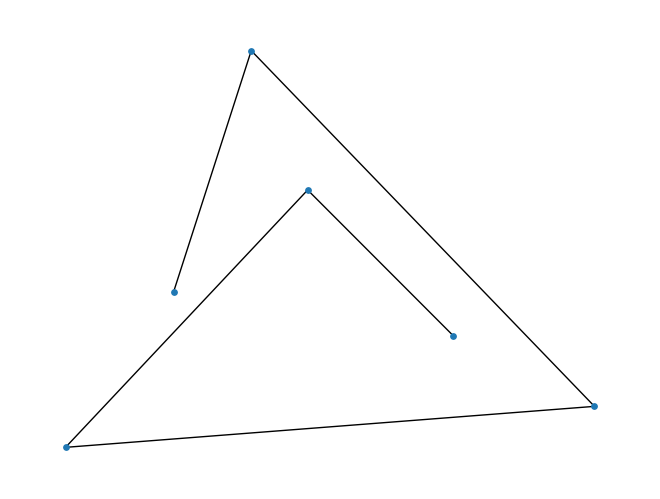

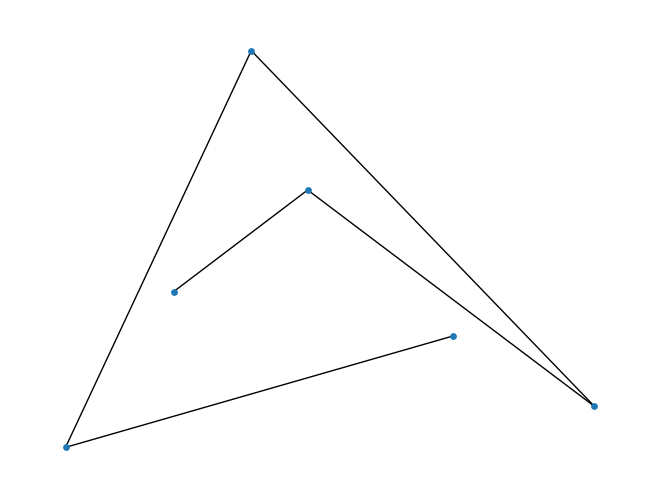

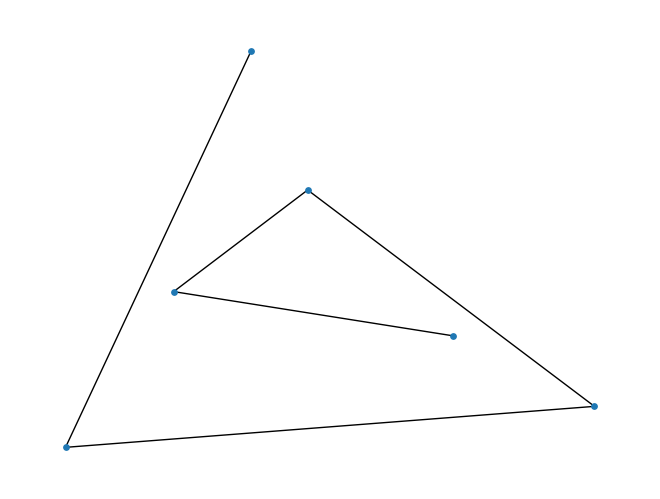

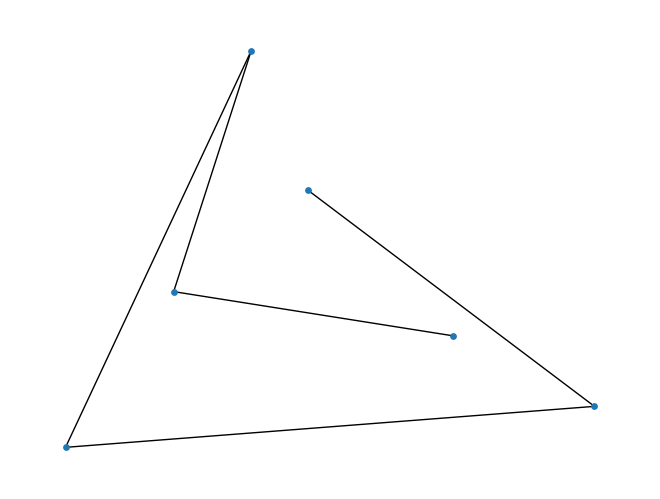

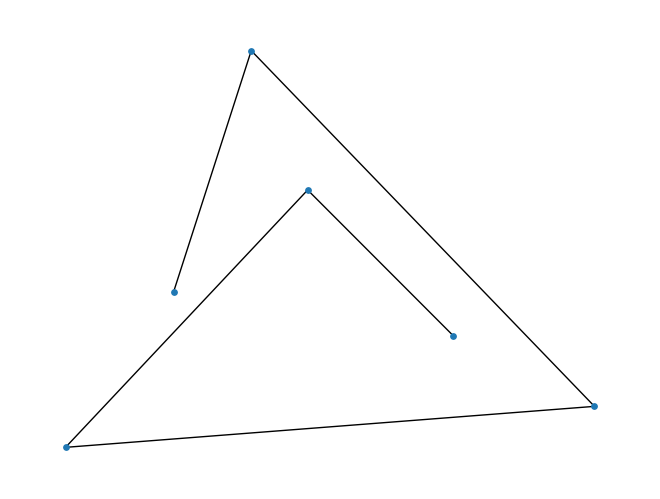

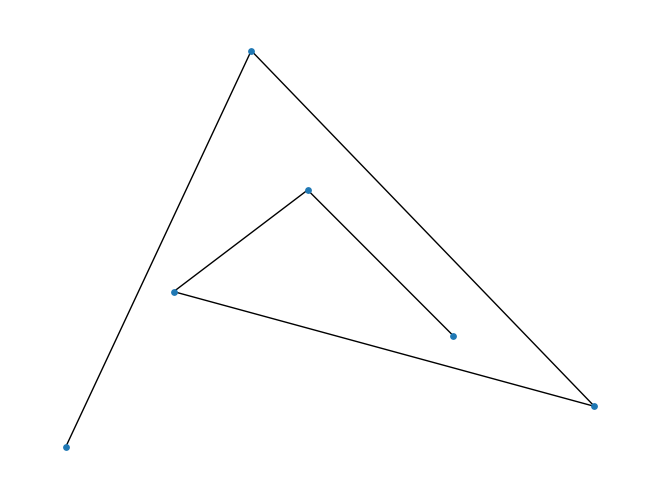

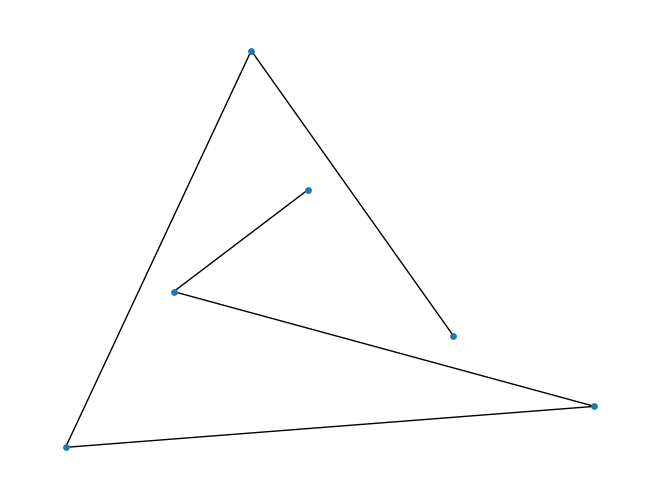

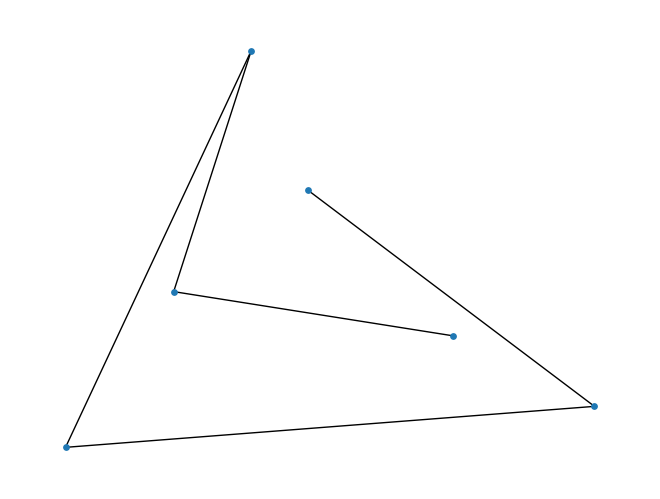

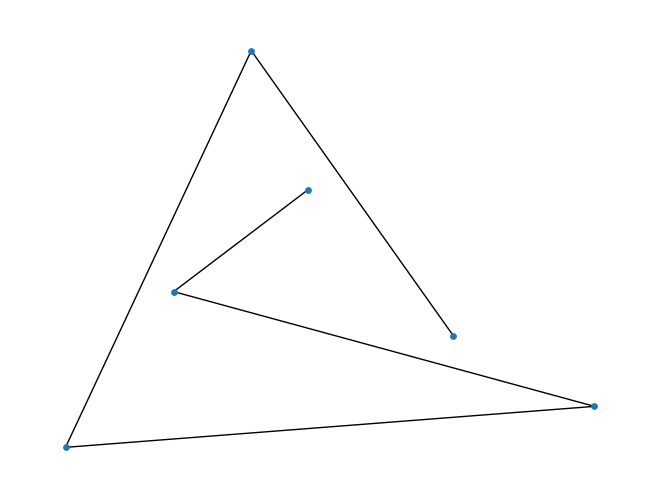

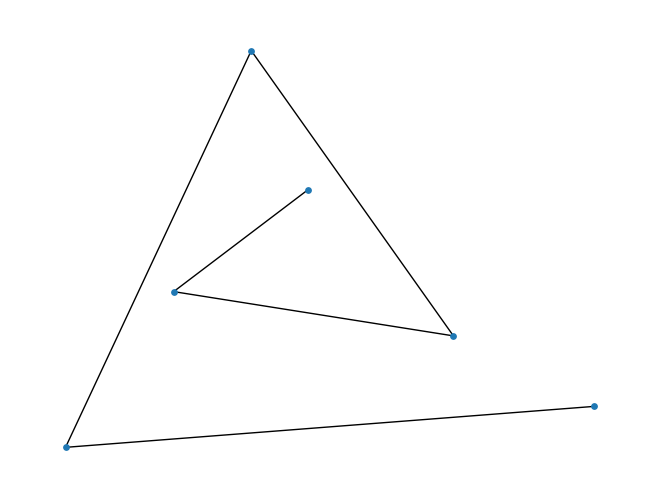

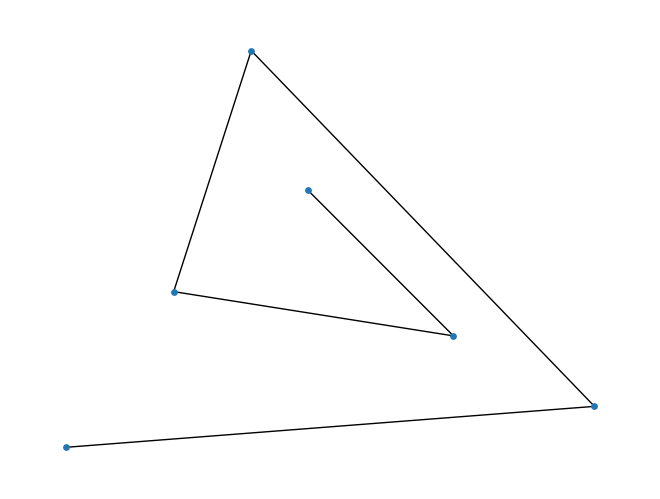

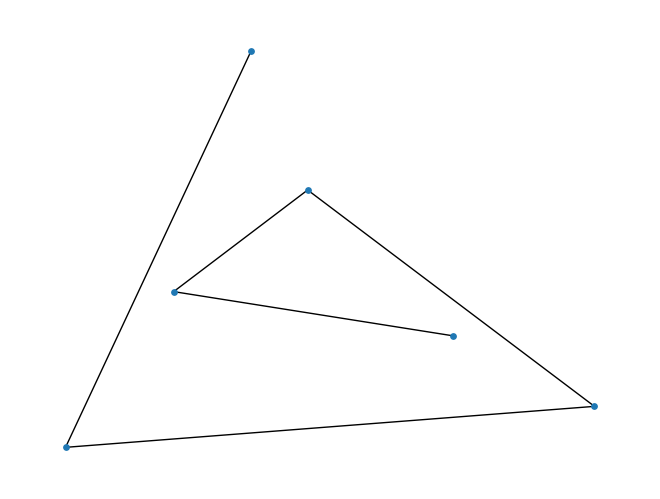

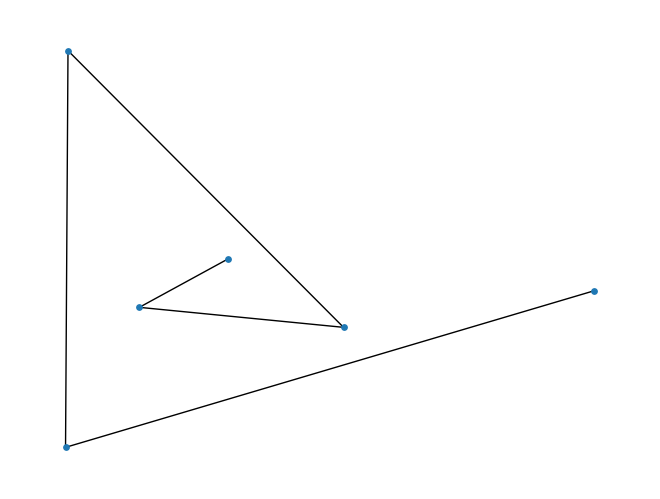

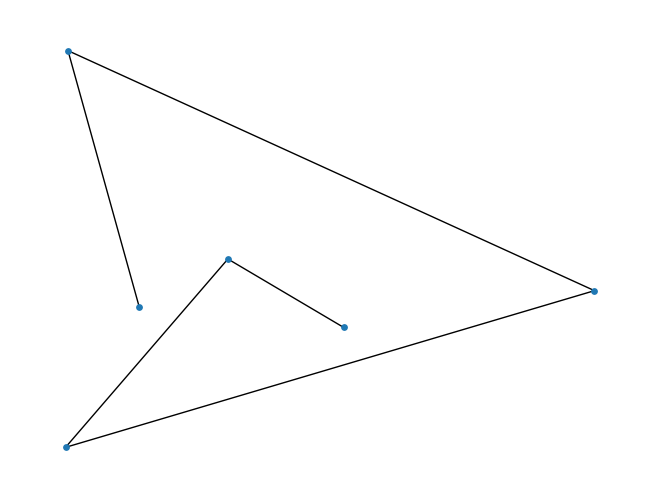

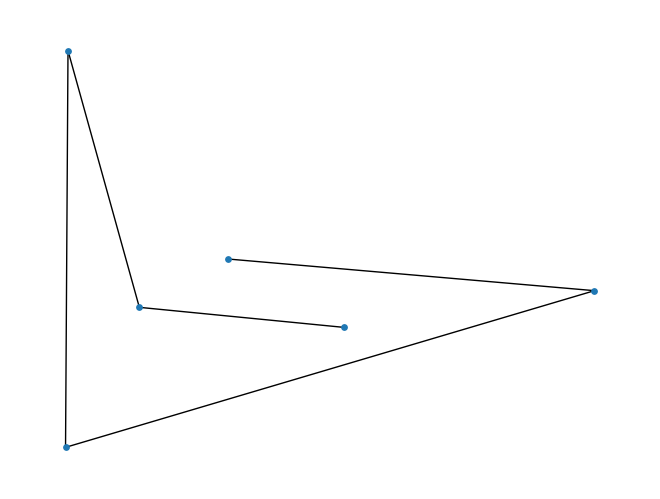

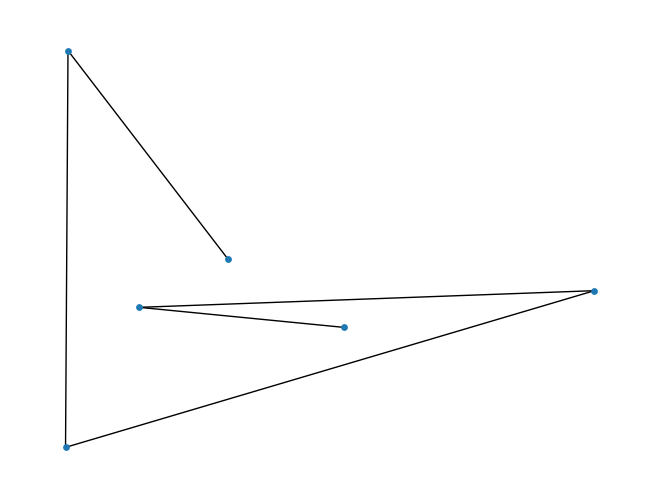

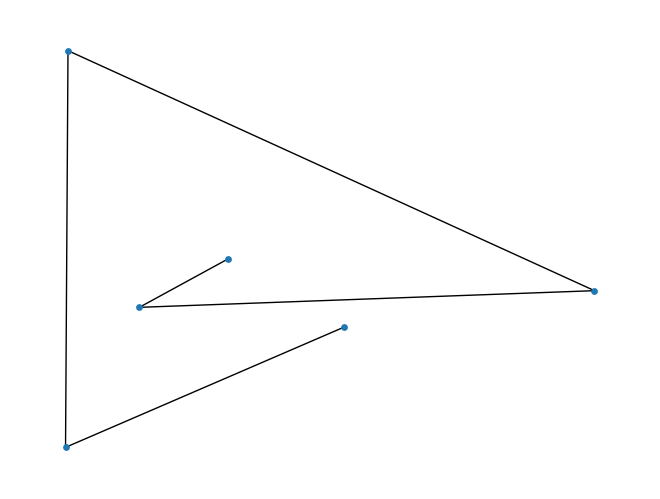

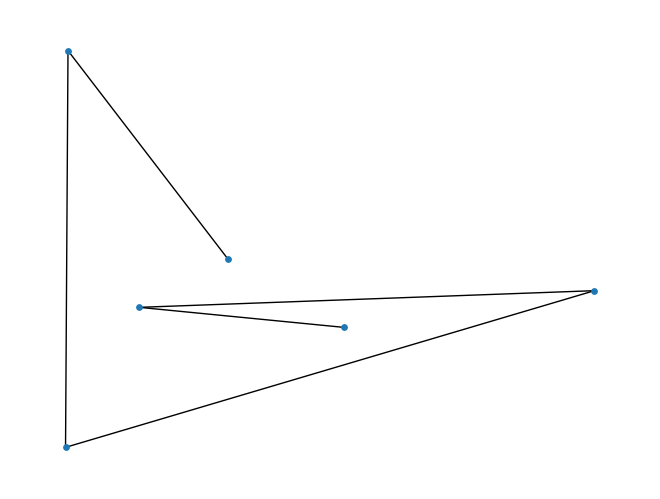

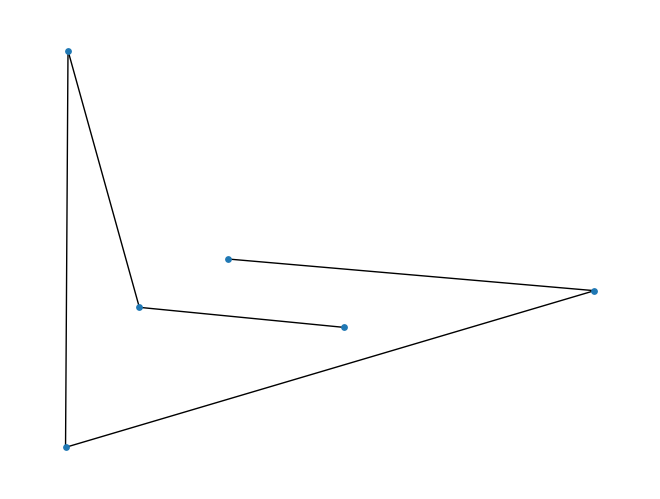

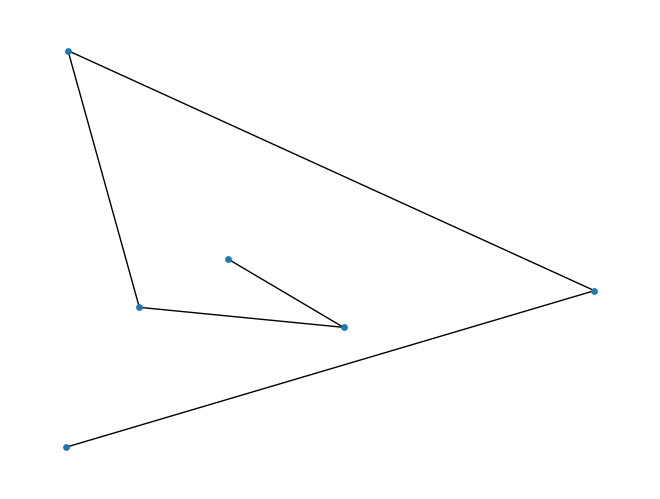

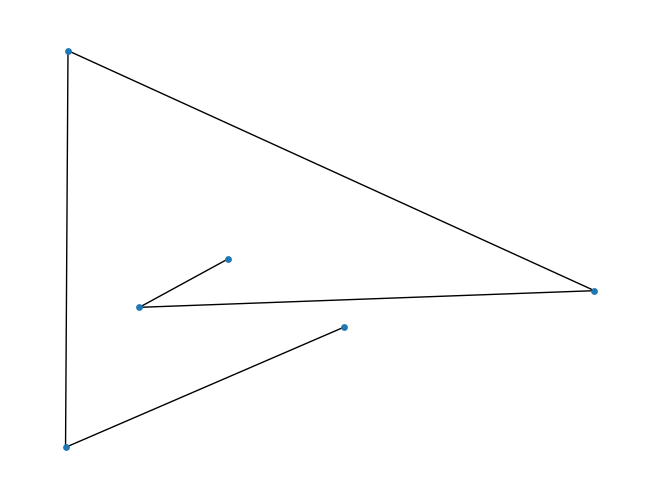

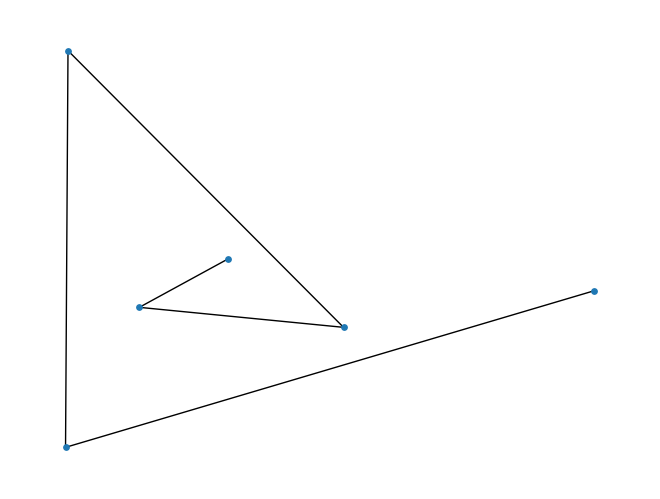

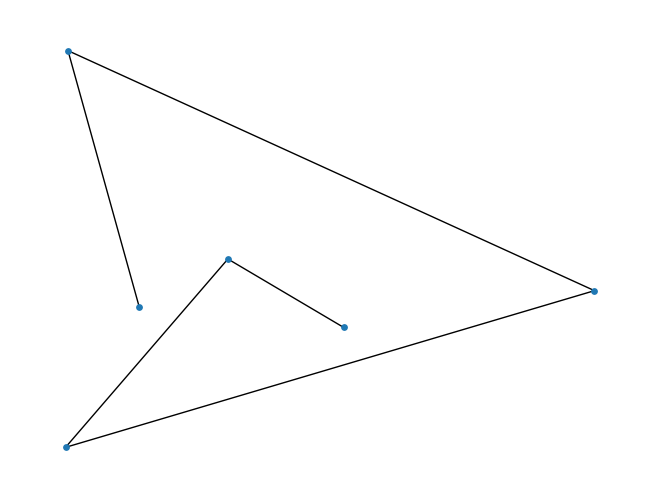

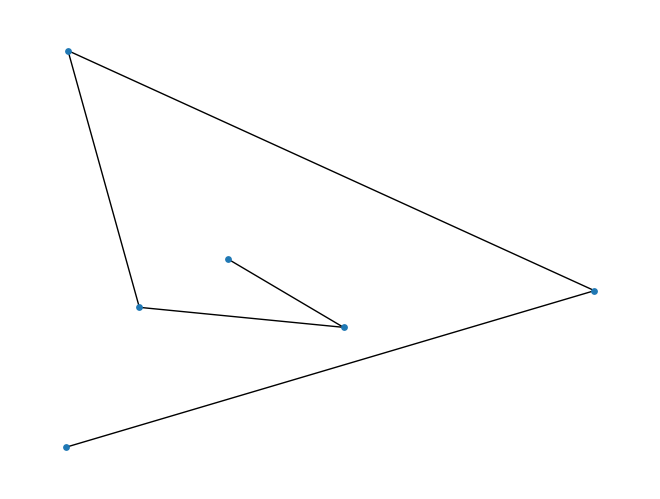

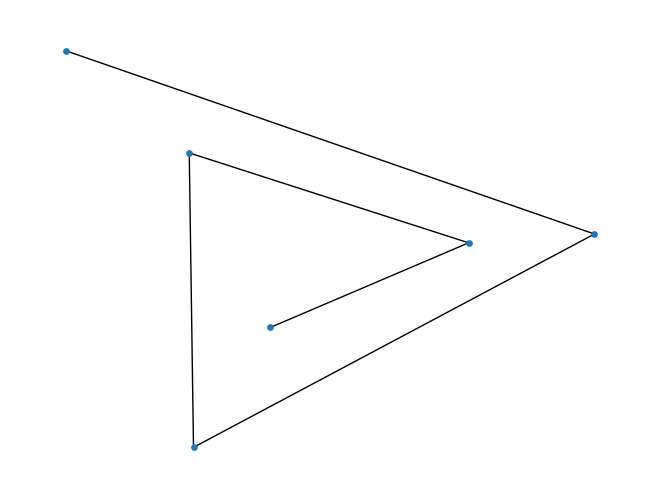

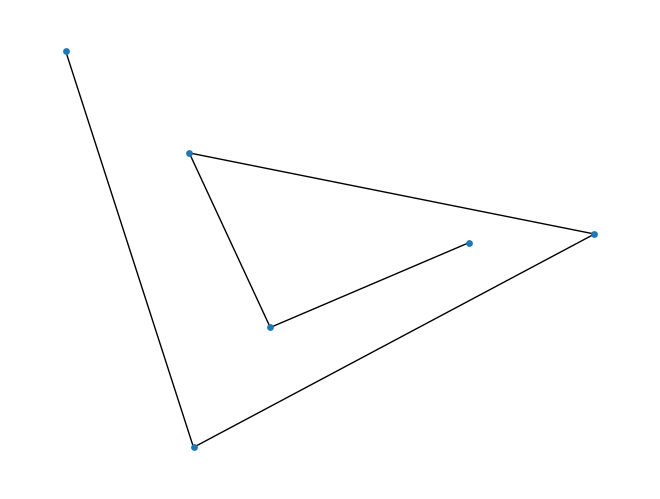

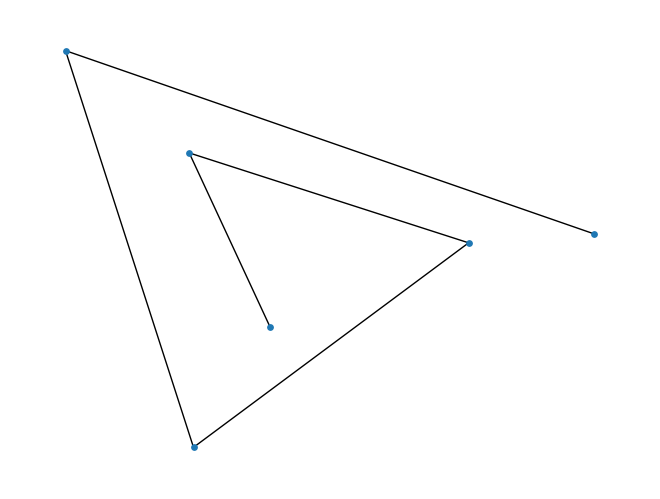

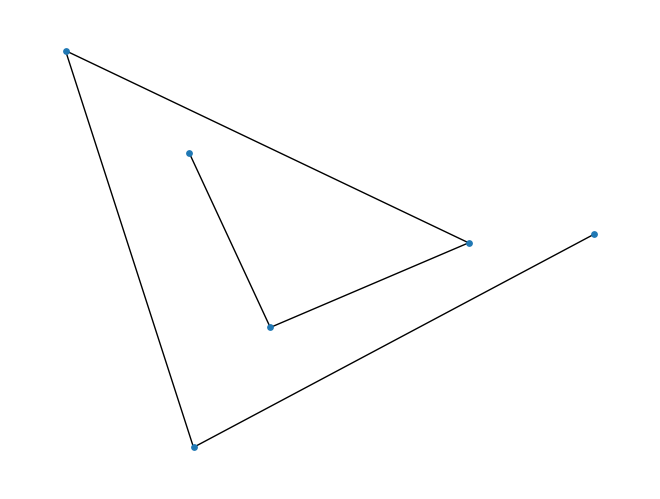

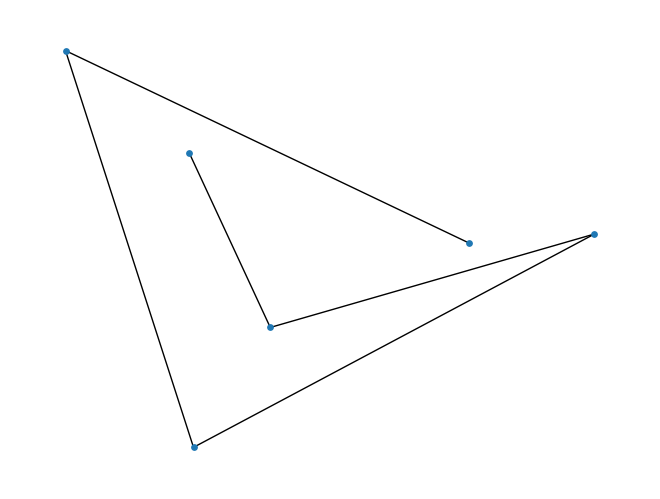

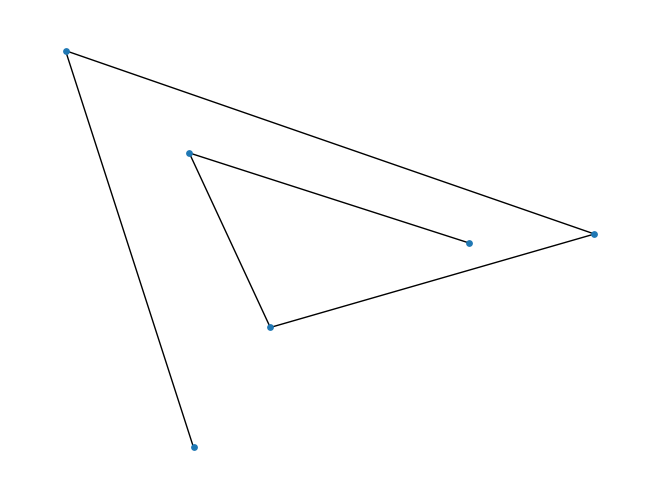

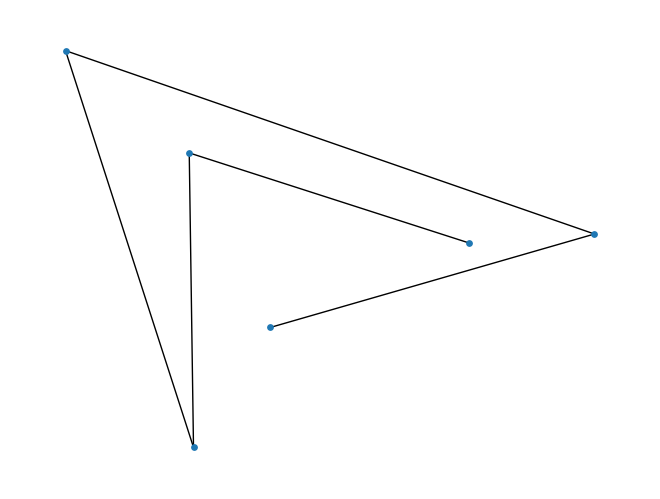

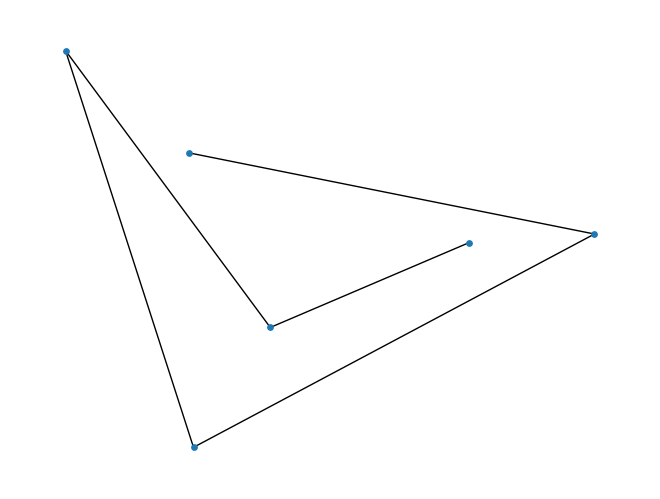

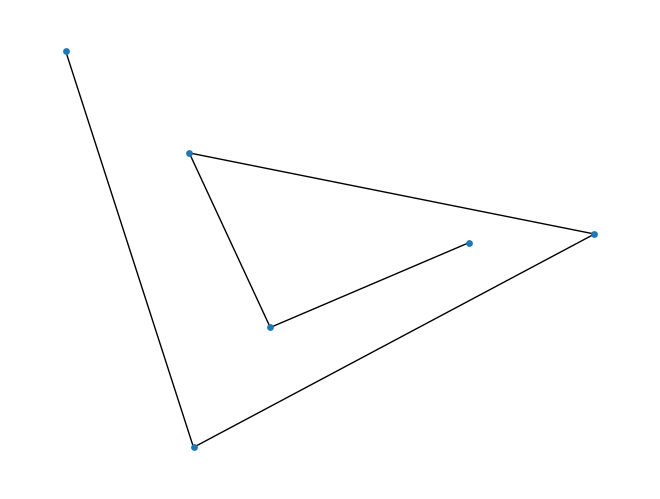

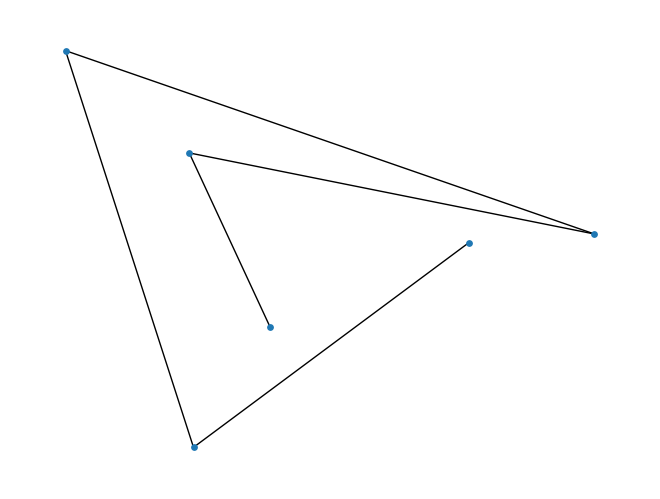

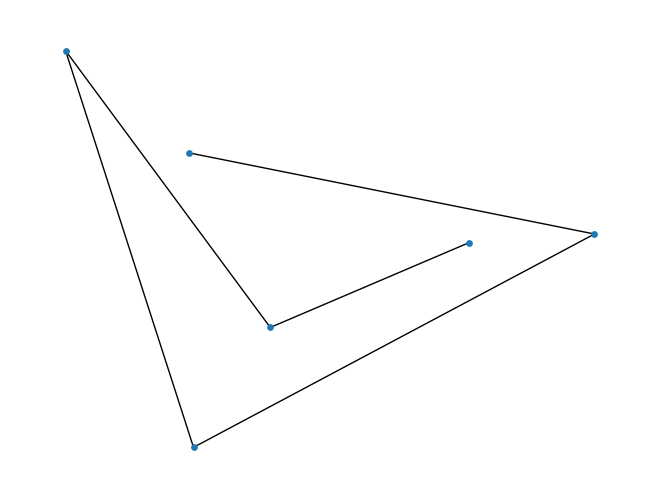

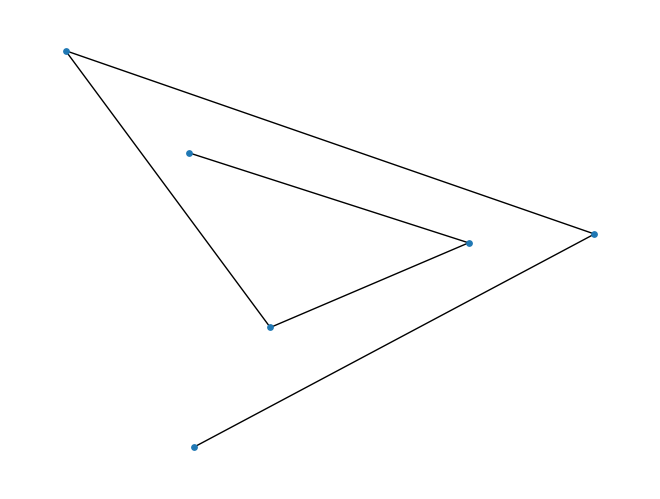

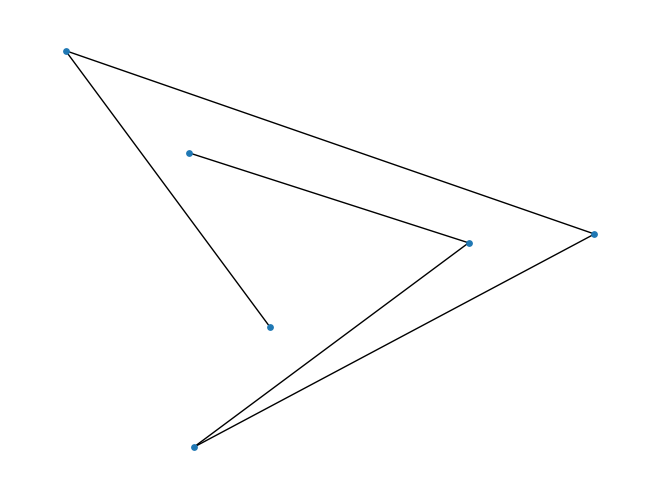

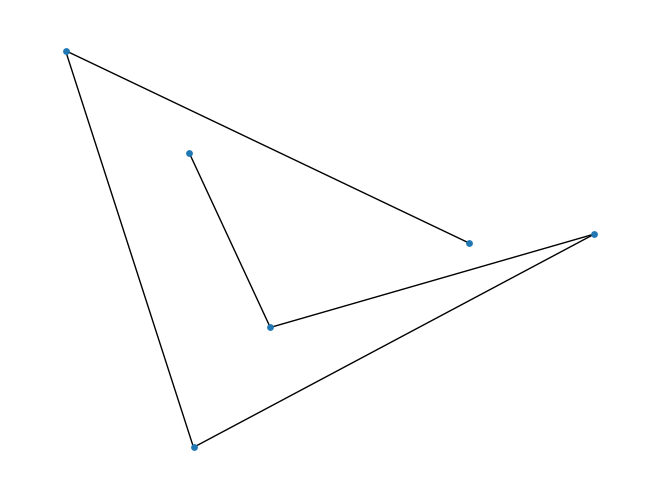

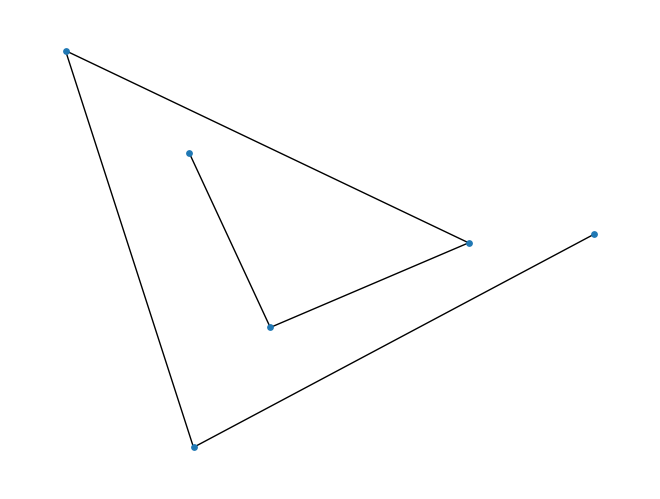

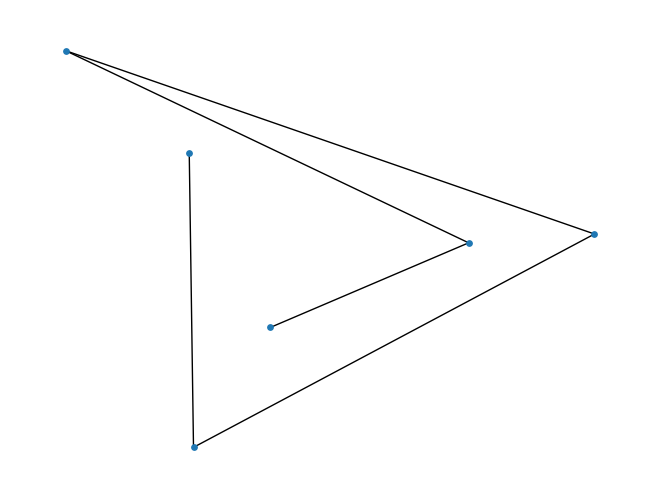

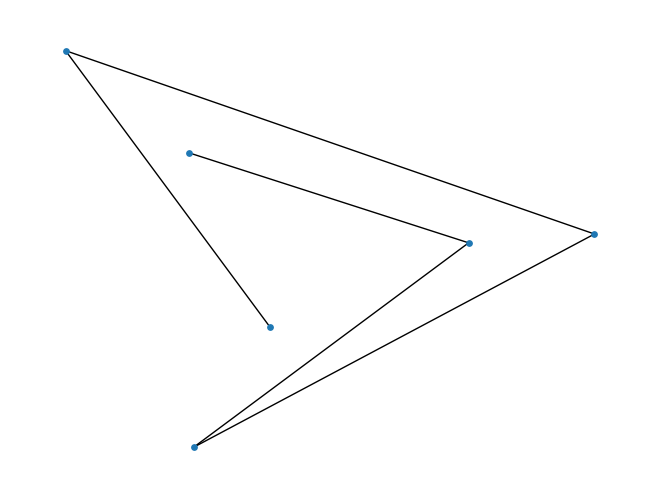

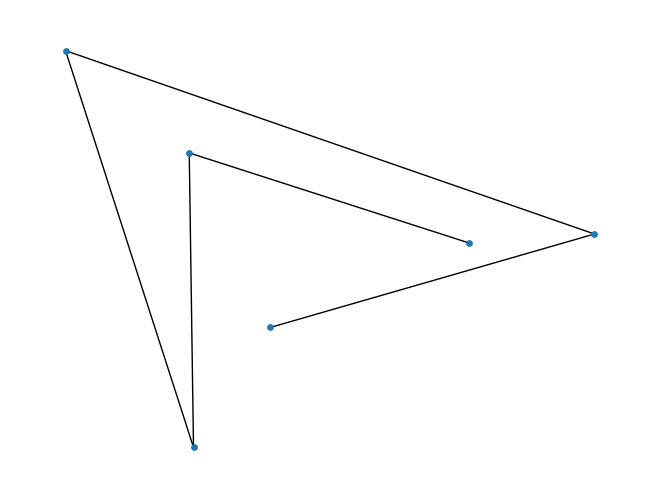

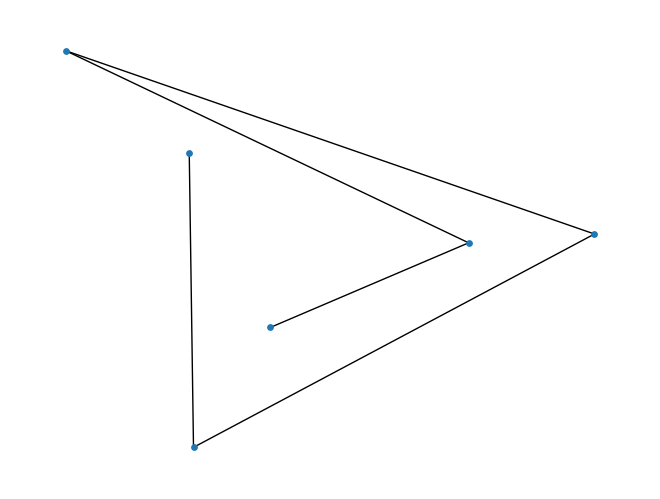

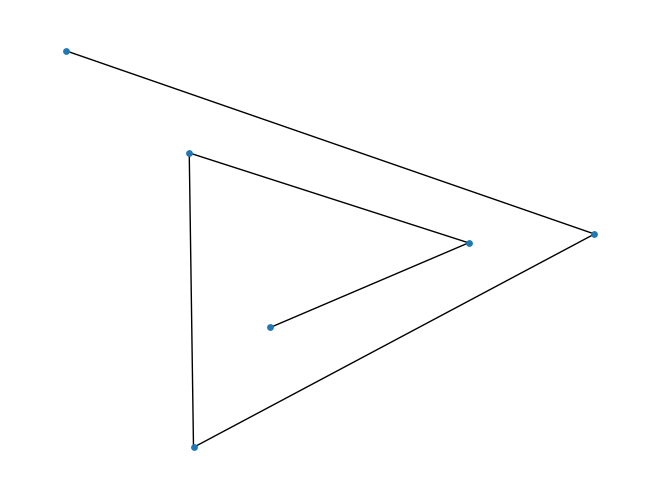

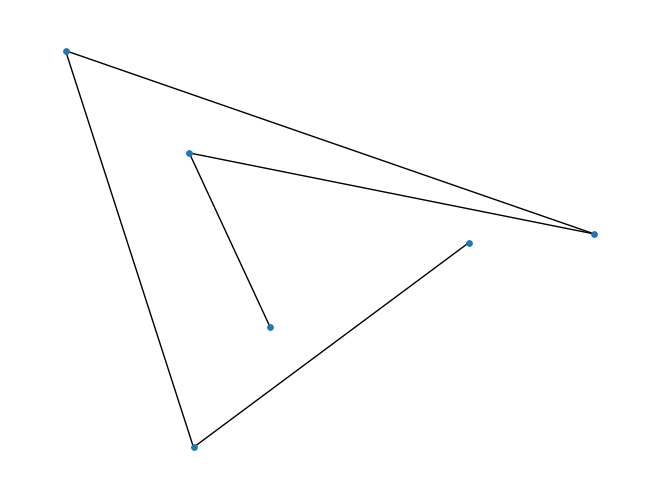

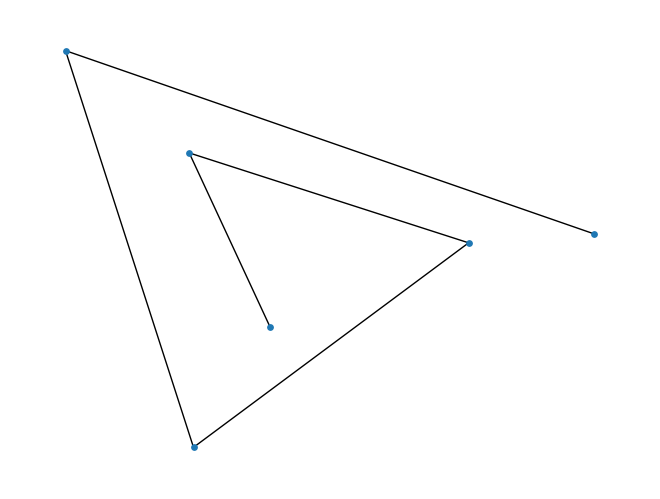

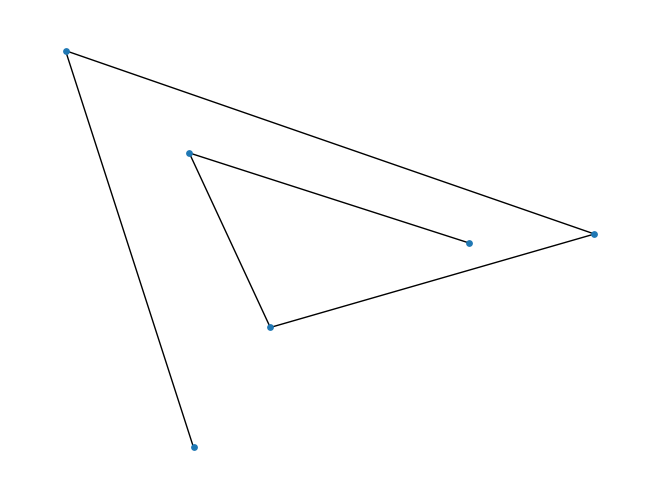

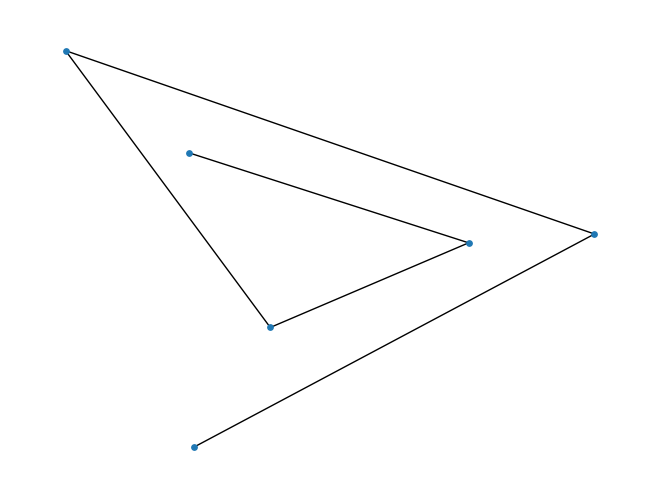

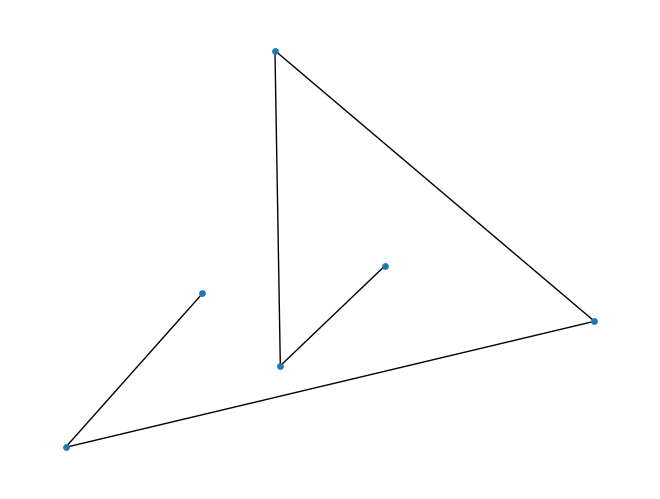

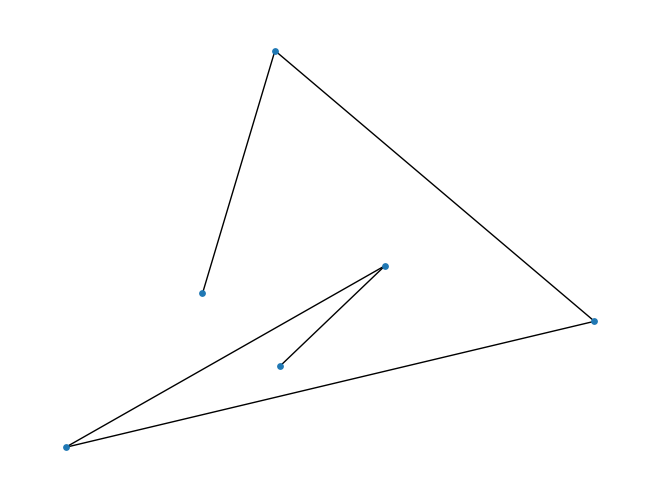

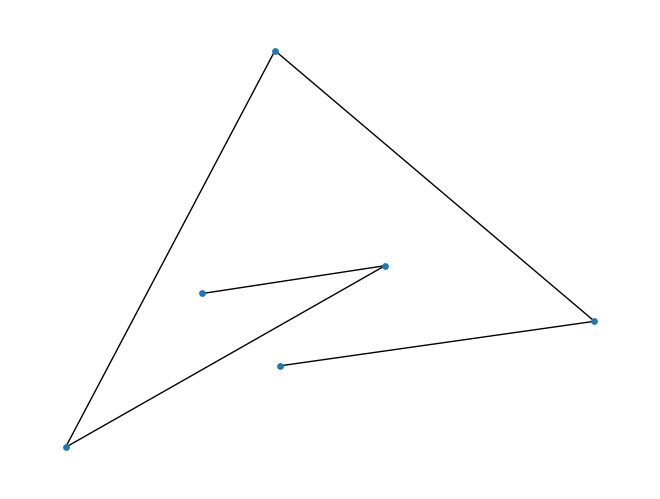

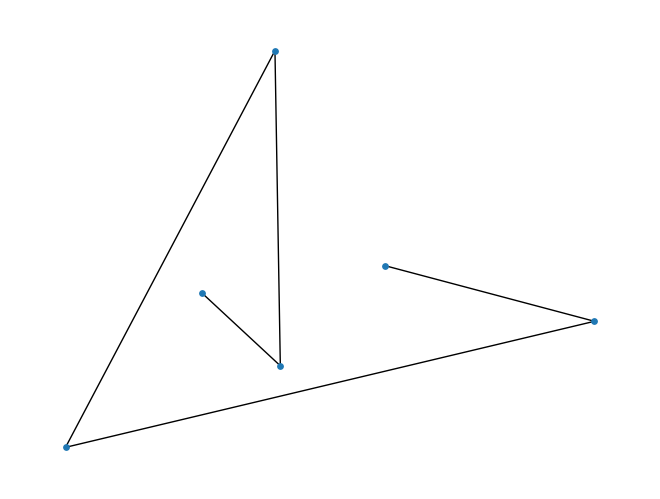

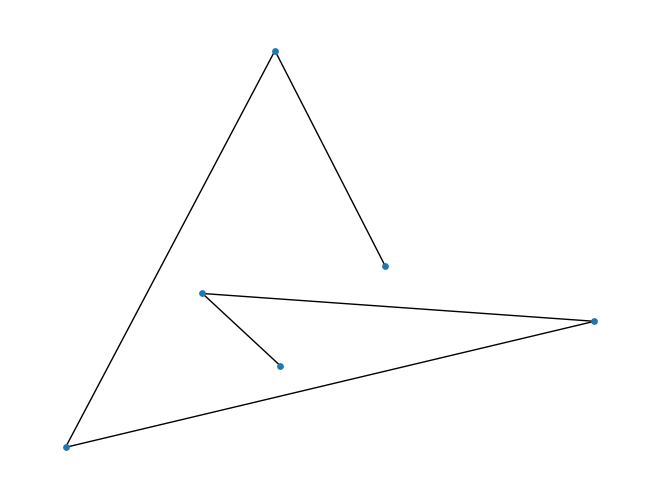

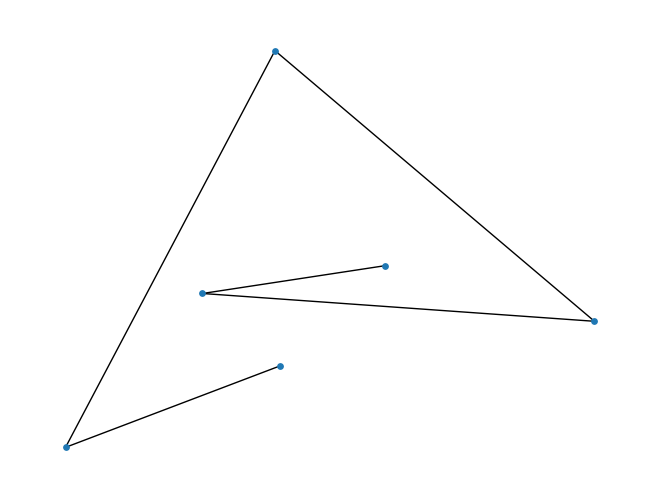

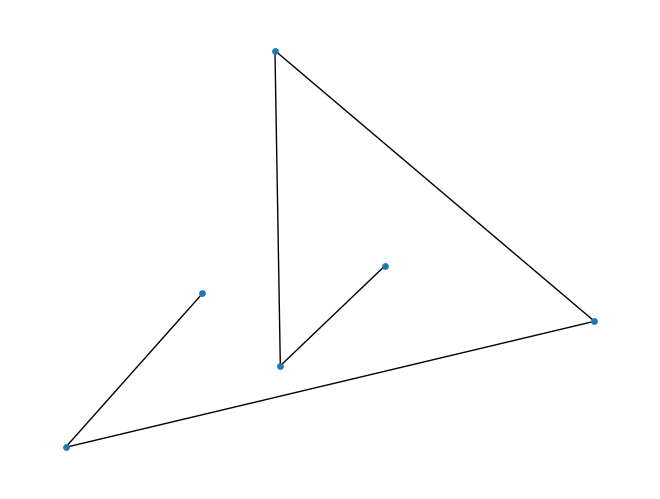

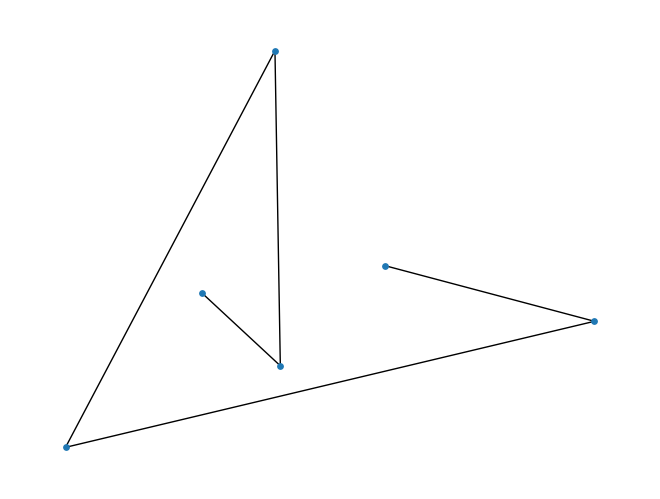

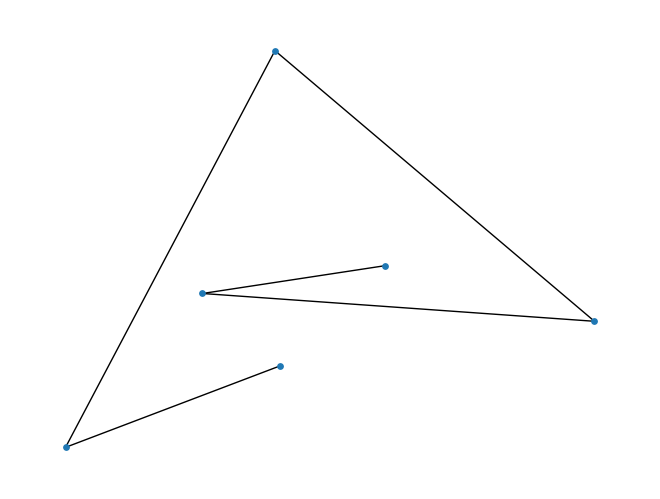

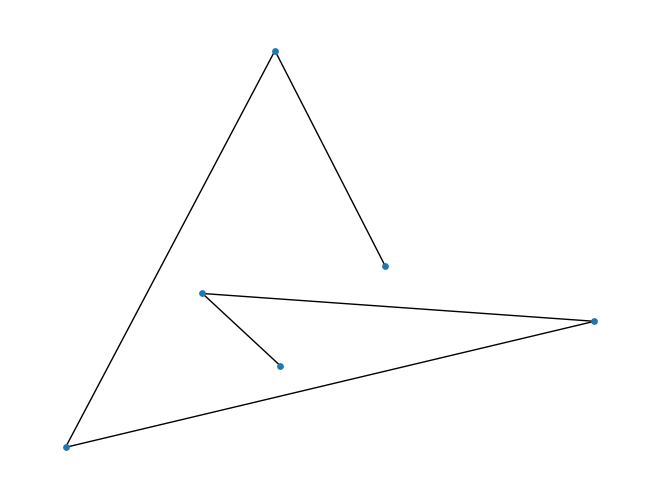

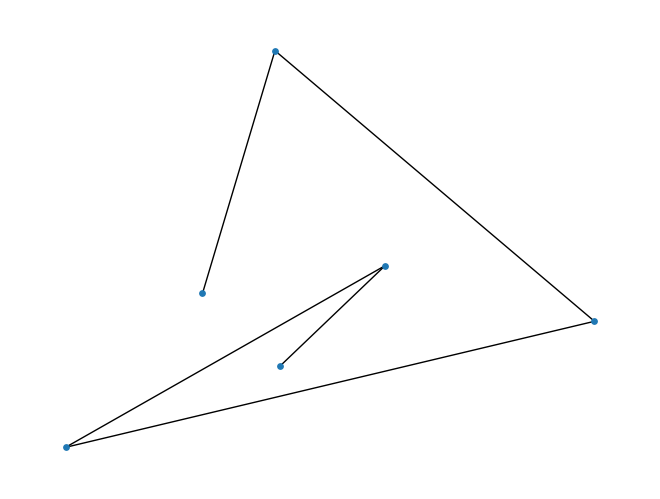

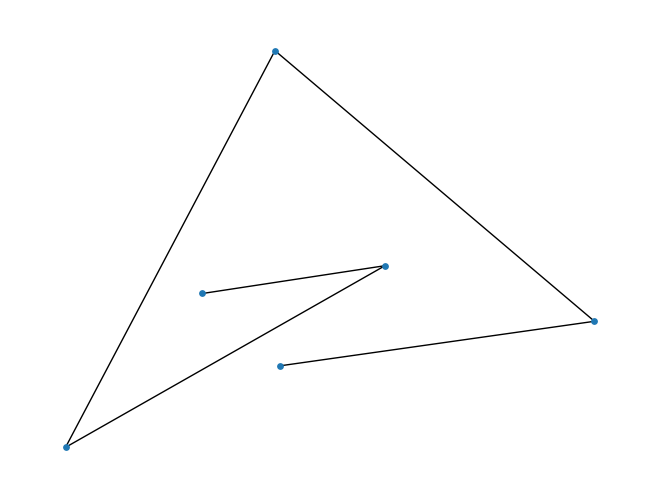

98


In [7]:
n=6
num = 0
for i in range(0,len(data),n):
  for P in itertools.permutations(data[i:i+n]):
    G = nx.Graph()
    for j in range(n): G.add_node(j, pos=P[j])
    G.add_edges_from([(k, k+1) for k in range(n - 1)])
    if check_planar(G) and len(check_empty_triangles(G))<=1:
      num += 1
      nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=15)
      plt.show()
      plt.close()

print(num)